In [1]:
utils_path = "../utils"
models_path = "../models"
data_path = "../data/celebs_105"

import sys
import os
sys.path.insert(1, utils_path)
sys.path.insert(2, models_path)

import torch
import torch.nn as nn

import matplotlib.pyplot as plt

import numpy as np

from comet_ml import Experiment

import config

import time 
import copy
import random
from tqdm.notebook import trange, tqdm

import torchvision

from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import datasets, transforms
import torchvision.transforms as transformss

from MBNV3 import MobileNetV3
from MBNV3CBAM import MobileNetV3CBAM

from dataloader import mixedSets
from functions import train, evaluate, confusion, unzip_files, unzip

In [2]:
#Initialising GereralTorch class

#Setting the experiment with the API key stored in config.py
experiment = Experiment(project_name = "Celebs_105_MobileNet", workspace = "leothesouthafrican", api_key = config.api_key)

#Report multiple hyperparameters using a dictionary
hyper_params = {
    'learning_rate': 0.001,
    'epochs': 200,
    'batch_size': 32,
    'image_size': 112,
    'image_channels': 3,
    'output_size': len(os.listdir(data_path)) - 1,
    'num_layers': 'na',
    'train_val_test_split': [0.8, 0.1, 0.1],
    'device': 'mps',
    'model_name': 'MobileNetV3 starting from a fresh model with no preloaded weights.',
    'criterion': 'CrossEntropyLoss',
    'optimizer': 'Adam',
    'dataset': 'Celebrities 20',
    'best_model_path': 'output/MN3L_celebs105.pt',
    'loaded_model_path': 'output/MN3L_celebs20.pt',
    'comet_exp': experiment,
    'save_at_end': True,
}

print(f'Output Size: {hyper_params["output_size"]}')

#Setting the device
device = torch.device(hyper_params['device'])

#checking if the model is to be a loaded one and if so loading it
if hyper_params['loaded_model_path']:
    state_dict = torch.load(hyper_params['loaded_model_path']) #Loading the state dict
    model = MobileNetV3(mode='large') #Loading the model as a backbone
    model.load_state_dict(state_dict, strict= True) #Loading the state dict into the model
    print('Model Loaded')
else:
    # Loading a fresh model
    model = MobileNetV3(mode='large')

#passing the model to the device
model.to(device)

# Setting the loss function and optimizer
criterion = nn.CrossEntropyLoss().to(device) #Setting the loss function
optimizer = torch.optim.Adam(model.parameters(), lr=hyper_params['learning_rate']) #Setting the optimizer

# Logging the hyperparameters to comet
experiment.log_parameters(hyper_params)

COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the following ML modules: torch. Metrics and hyperparameters can still be logged using Experiment.log_metrics() and Experiment.log_parameters()
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/leothesouthafrican/celebs-20-mobilenet/c25a4398f2ef4ed592631a9a73dcc2ab



Output Size: 20


In [3]:
#defining transforms

train_transform = transforms.Compose([
                transforms.Resize((hyper_params['image_size'],hyper_params['image_size'])),
                transforms.ToTensor(),
                transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]),
                transforms.RandomApply([transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
                transforms.RandomCrop(hyper_params['image_size'], padding=2)], p=0.2),
                transforms.RandomAffine(degrees=10, translate=(0.1,0.1), scale=(0.8,1.2)),
                transforms.RandomRotation(15),
                transforms.RandomHorizontalFlip(0.15),
                transforms.RandomVerticalFlip(0.1),
                transforms.RandomErasing(0.1),
            ])

test_transform = transforms.Compose([
                transforms.Resize((hyper_params['image_size'],hyper_params['image_size'])),
                transforms.ToTensor(),
                transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
            ])

In [4]:
# Creating the dataset
train_dataset = mixedSets(data_path, train_transform, hyper_params['train_val_test_split']).get_train_dataset()
val_dataset = mixedSets(data_path, test_transform, hyper_params['train_val_test_split']).get_val_dataset()
test_dataset = mixedSets(data_path, test_transform, hyper_params['train_val_test_split']).get_test_dataset()

# Creating the dataloaders
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                            batch_size=hyper_params['batch_size'],
                                            shuffle=True,
                                            num_workers=1)

val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                            batch_size=hyper_params['batch_size'],
                                            shuffle=True,
                                            num_workers=1)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                            batch_size=hyper_params['batch_size'],
                                            shuffle=True,
                                            num_workers=1)


Train dataset size: 2642, with 20 classes
Val dataset size: 331, with 20 classes
Test dataset size: 331, with 20 classes


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


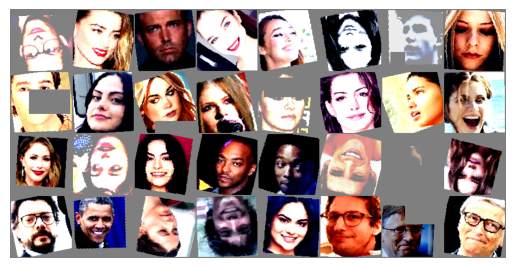

tensor(5) tensor(16) tensor(9) tensor(18)


In [5]:
#display random images from the dataset
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    #drop axis labels
    plt.axis('off')
    plt.show()

# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % labels[j] for j in range(4)))

In [6]:
with experiment.train():
    train(model, criterion, optimizer, hyper_params, train_loader, val_loader)

Begin training...


100%|██████████| 11/11 [00:06<00:00,  1.62it/s]


Best model saved at epoch 2 with accuracy 0.0725 and loss 2.9852.
	Train Loss: 3.044 | Train Acc: 11.11%
Epoch: 02 | Epoch Time: 0m 34s
	 Val. Loss: 2.985 |  Val. Acc: 7.25%


100%|██████████| 11/11 [00:06<00:00,  1.79it/s]


Best model saved at epoch 3 with accuracy 0.0785 and loss 2.9343.
	Train Loss: 2.872 | Train Acc: 5.56%
Epoch: 03 | Epoch Time: 0m 29s
	 Val. Loss: 2.934 |  Val. Acc: 7.85%


100%|██████████| 11/11 [00:06<00:00,  1.78it/s]


Best model saved at epoch 4 with accuracy 0.139 and loss 2.9254.
	Train Loss: 2.788 | Train Acc: 22.22%
Epoch: 04 | Epoch Time: 0m 29s
	 Val. Loss: 2.925 |  Val. Acc: 13.90%


100%|██████████| 11/11 [00:06<00:00,  1.79it/s]


Best model saved at epoch 5 with accuracy 0.148 and loss 2.7889.
	Train Loss: 2.766 | Train Acc: 16.67%
Epoch: 05 | Epoch Time: 0m 29s
	 Val. Loss: 2.789 |  Val. Acc: 14.80%


100%|██████████| 11/11 [00:06<00:00,  1.78it/s]


Best model saved at epoch 6 with accuracy 0.1662 and loss 2.6834.
	Train Loss: 2.670 | Train Acc: 22.22%
Epoch: 06 | Epoch Time: 0m 29s
	 Val. Loss: 2.683 |  Val. Acc: 16.62%


100%|██████████| 11/11 [00:06<00:00,  1.74it/s]


	Train Loss: 2.698 | Train Acc: 16.67%
Epoch: 07 | Epoch Time: 0m 30s
	 Val. Loss: 2.639 |  Val. Acc: 15.71%


100%|██████████| 11/11 [00:06<00:00,  1.73it/s]


	Train Loss: 2.509 | Train Acc: 27.78%
Epoch: 08 | Epoch Time: 0m 29s
	 Val. Loss: 2.694 |  Val. Acc: 13.29%


100%|██████████| 11/11 [00:06<00:00,  1.72it/s]


Best model saved at epoch 9 with accuracy 0.1782 and loss 2.768.
	Train Loss: 3.198 | Train Acc: 5.56%
Epoch: 09 | Epoch Time: 0m 32s
	 Val. Loss: 2.768 |  Val. Acc: 17.82%


100%|██████████| 11/11 [00:06<00:00,  1.72it/s]


Best model saved at epoch 10 with accuracy 0.1934 and loss 2.5734.
	Train Loss: 2.764 | Train Acc: 11.11%
Epoch: 10 | Epoch Time: 0m 33s
	 Val. Loss: 2.573 |  Val. Acc: 19.34%


100%|██████████| 11/11 [00:06<00:00,  1.70it/s]


Best model saved at epoch 11 with accuracy 0.1994 and loss 2.6328.
	Train Loss: 2.810 | Train Acc: 33.33%
Epoch: 11 | Epoch Time: 0m 34s
	 Val. Loss: 2.633 |  Val. Acc: 19.94%


100%|██████████| 11/11 [00:06<00:00,  1.74it/s]


	Train Loss: 2.423 | Train Acc: 27.78%
Epoch: 12 | Epoch Time: 0m 33s
	 Val. Loss: 2.568 |  Val. Acc: 18.73%


100%|██████████| 11/11 [00:06<00:00,  1.74it/s]


	Train Loss: 2.555 | Train Acc: 16.67%
Epoch: 13 | Epoch Time: 0m 32s
	 Val. Loss: 2.513 |  Val. Acc: 16.01%


100%|██████████| 11/11 [00:06<00:00,  1.74it/s]


Best model saved at epoch 14 with accuracy 0.2205 and loss 2.472.
	Train Loss: 2.884 | Train Acc: 16.67%
Epoch: 14 | Epoch Time: 0m 32s
	 Val. Loss: 2.472 |  Val. Acc: 22.05%


100%|██████████| 11/11 [00:06<00:00,  1.72it/s]


	Train Loss: 2.353 | Train Acc: 16.67%
Epoch: 15 | Epoch Time: 0m 31s
	 Val. Loss: 2.418 |  Val. Acc: 20.85%


100%|██████████| 11/11 [00:06<00:00,  1.73it/s]


	Train Loss: 2.401 | Train Acc: 22.22%
Epoch: 16 | Epoch Time: 0m 31s
	 Val. Loss: 2.410 |  Val. Acc: 22.05%


100%|██████████| 11/11 [00:06<00:00,  1.73it/s]


Best model saved at epoch 17 with accuracy 0.2296 and loss 2.4763.
	Train Loss: 2.393 | Train Acc: 33.33%
Epoch: 17 | Epoch Time: 0m 30s
	 Val. Loss: 2.476 |  Val. Acc: 22.96%


100%|██████████| 11/11 [00:06<00:00,  1.74it/s]


	Train Loss: 2.523 | Train Acc: 22.22%
Epoch: 18 | Epoch Time: 0m 29s
	 Val. Loss: 2.412 |  Val. Acc: 18.13%


100%|██████████| 11/11 [00:06<00:00,  1.74it/s]


	Train Loss: 2.351 | Train Acc: 11.11%
Epoch: 19 | Epoch Time: 0m 29s
	 Val. Loss: 2.415 |  Val. Acc: 18.13%


100%|██████████| 11/11 [00:06<00:00,  1.75it/s]


	Train Loss: 2.428 | Train Acc: 27.78%
Epoch: 20 | Epoch Time: 0m 29s
	 Val. Loss: 2.351 |  Val. Acc: 22.96%


100%|██████████| 11/11 [00:06<00:00,  1.73it/s]


Best model saved at epoch 21 with accuracy 0.2508 and loss 2.3291.
	Train Loss: 2.392 | Train Acc: 22.22%
Epoch: 21 | Epoch Time: 0m 29s
	 Val. Loss: 2.329 |  Val. Acc: 25.08%


100%|██████████| 11/11 [00:06<00:00,  1.78it/s]


Best model saved at epoch 22 with accuracy 0.2659 and loss 2.1935.
	Train Loss: 2.795 | Train Acc: 16.67%
Epoch: 22 | Epoch Time: 0m 29s
	 Val. Loss: 2.193 |  Val. Acc: 26.59%


100%|██████████| 11/11 [00:06<00:00,  1.73it/s]


	Train Loss: 2.579 | Train Acc: 33.33%
Epoch: 23 | Epoch Time: 0m 29s
	 Val. Loss: 2.321 |  Val. Acc: 21.45%


100%|██████████| 11/11 [00:06<00:00,  1.75it/s]


	Train Loss: 2.875 | Train Acc: 0.00%
Epoch: 24 | Epoch Time: 0m 29s
	 Val. Loss: 2.329 |  Val. Acc: 24.77%


100%|██████████| 11/11 [00:06<00:00,  1.75it/s]


Best model saved at epoch 25 with accuracy 0.2931 and loss 2.1219.
	Train Loss: 2.321 | Train Acc: 33.33%
Epoch: 25 | Epoch Time: 0m 29s
	 Val. Loss: 2.122 |  Val. Acc: 29.31%


100%|██████████| 11/11 [00:06<00:00,  1.75it/s]


	Train Loss: 2.058 | Train Acc: 38.89%
Epoch: 26 | Epoch Time: 0m 28s
	 Val. Loss: 2.229 |  Val. Acc: 29.31%


100%|██████████| 11/11 [00:06<00:00,  1.73it/s]


	Train Loss: 1.857 | Train Acc: 44.44%
Epoch: 27 | Epoch Time: 0m 29s
	 Val. Loss: 2.191 |  Val. Acc: 25.68%


100%|██████████| 11/11 [00:06<00:00,  1.77it/s]


Best model saved at epoch 28 with accuracy 0.3112 and loss 2.1309.
	Train Loss: 2.831 | Train Acc: 5.56%
Epoch: 28 | Epoch Time: 0m 29s
	 Val. Loss: 2.131 |  Val. Acc: 31.12%


100%|██████████| 11/11 [00:06<00:00,  1.74it/s]


Best model saved at epoch 29 with accuracy 0.3233 and loss 2.1282.
	Train Loss: 2.331 | Train Acc: 33.33%
Epoch: 29 | Epoch Time: 0m 29s
	 Val. Loss: 2.128 |  Val. Acc: 32.33%


100%|██████████| 11/11 [00:06<00:00,  1.73it/s]


	Train Loss: 2.329 | Train Acc: 22.22%
Epoch: 30 | Epoch Time: 0m 29s
	 Val. Loss: 2.170 |  Val. Acc: 29.91%


100%|██████████| 11/11 [00:06<00:00,  1.73it/s]


	Train Loss: 2.219 | Train Acc: 27.78%
Epoch: 31 | Epoch Time: 0m 29s
	 Val. Loss: 2.025 |  Val. Acc: 32.33%


100%|██████████| 11/11 [00:06<00:00,  1.75it/s]


	Train Loss: 2.346 | Train Acc: 27.78%
Epoch: 32 | Epoch Time: 0m 29s
	 Val. Loss: 2.165 |  Val. Acc: 28.70%


100%|██████████| 11/11 [00:06<00:00,  1.73it/s]


	Train Loss: 2.371 | Train Acc: 22.22%
Epoch: 33 | Epoch Time: 0m 29s
	 Val. Loss: 2.097 |  Val. Acc: 30.82%


100%|██████████| 11/11 [00:06<00:00,  1.72it/s]


Best model saved at epoch 34 with accuracy 0.3776 and loss 2.0101.
	Train Loss: 2.260 | Train Acc: 22.22%
Epoch: 34 | Epoch Time: 0m 29s
	 Val. Loss: 2.010 |  Val. Acc: 37.76%


100%|██████████| 11/11 [00:06<00:00,  1.73it/s]


	Train Loss: 2.631 | Train Acc: 11.11%
Epoch: 35 | Epoch Time: 0m 29s
	 Val. Loss: 2.021 |  Val. Acc: 31.12%


100%|██████████| 11/11 [00:06<00:00,  1.73it/s]


	Train Loss: 1.710 | Train Acc: 33.33%
Epoch: 36 | Epoch Time: 0m 29s
	 Val. Loss: 1.919 |  Val. Acc: 37.46%


100%|██████████| 11/11 [00:06<00:00,  1.72it/s]


Best model saved at epoch 37 with accuracy 0.3927 and loss 1.8706.
	Train Loss: 2.419 | Train Acc: 22.22%
Epoch: 37 | Epoch Time: 0m 29s
	 Val. Loss: 1.871 |  Val. Acc: 39.27%


100%|██████████| 11/11 [00:06<00:00,  1.71it/s]


	Train Loss: 2.675 | Train Acc: 16.67%
Epoch: 38 | Epoch Time: 0m 29s
	 Val. Loss: 2.096 |  Val. Acc: 32.02%


100%|██████████| 11/11 [00:06<00:00,  1.77it/s]


	Train Loss: 2.539 | Train Acc: 16.67%
Epoch: 39 | Epoch Time: 0m 29s
	 Val. Loss: 1.930 |  Val. Acc: 38.37%


100%|██████████| 11/11 [00:06<00:00,  1.78it/s]


	Train Loss: 1.825 | Train Acc: 44.44%
Epoch: 40 | Epoch Time: 0m 29s
	 Val. Loss: 1.923 |  Val. Acc: 38.97%


100%|██████████| 11/11 [00:06<00:00,  1.77it/s]


	Train Loss: 2.083 | Train Acc: 16.67%
Epoch: 41 | Epoch Time: 0m 29s
	 Val. Loss: 1.921 |  Val. Acc: 36.56%


100%|██████████| 11/11 [00:06<00:00,  1.73it/s]


	Train Loss: 2.614 | Train Acc: 16.67%
Epoch: 42 | Epoch Time: 0m 29s
	 Val. Loss: 1.776 |  Val. Acc: 38.97%


100%|██████████| 11/11 [00:06<00:00,  1.73it/s]


	Train Loss: 2.603 | Train Acc: 27.78%
Epoch: 43 | Epoch Time: 0m 29s
	 Val. Loss: 1.875 |  Val. Acc: 38.67%


100%|██████████| 11/11 [00:06<00:00,  1.74it/s]


Best model saved at epoch 44 with accuracy 0.4079 and loss 1.8768.
	Train Loss: 2.258 | Train Acc: 33.33%
Epoch: 44 | Epoch Time: 0m 29s
	 Val. Loss: 1.877 |  Val. Acc: 40.79%


100%|██████████| 11/11 [00:06<00:00,  1.73it/s]


	Train Loss: 1.893 | Train Acc: 33.33%
Epoch: 45 | Epoch Time: 0m 29s
	 Val. Loss: 1.933 |  Val. Acc: 40.18%


100%|██████████| 11/11 [00:06<00:00,  1.72it/s]


	Train Loss: 2.171 | Train Acc: 22.22%
Epoch: 46 | Epoch Time: 0m 29s
	 Val. Loss: 1.899 |  Val. Acc: 37.76%


100%|██████████| 11/11 [00:06<00:00,  1.72it/s]


Best model saved at epoch 47 with accuracy 0.432 and loss 1.782.
	Train Loss: 1.812 | Train Acc: 27.78%
Epoch: 47 | Epoch Time: 0m 29s
	 Val. Loss: 1.782 |  Val. Acc: 43.20%


100%|██████████| 11/11 [00:06<00:00,  1.72it/s]


Best model saved at epoch 48 with accuracy 0.4653 and loss 1.7118.
	Train Loss: 2.829 | Train Acc: 16.67%
Epoch: 48 | Epoch Time: 0m 29s
	 Val. Loss: 1.712 |  Val. Acc: 46.53%


100%|██████████| 11/11 [00:06<00:00,  1.74it/s]


	Train Loss: 2.368 | Train Acc: 33.33%
Epoch: 49 | Epoch Time: 0m 29s
	 Val. Loss: 1.823 |  Val. Acc: 40.48%


100%|██████████| 11/11 [00:06<00:00,  1.73it/s]


	Train Loss: 1.995 | Train Acc: 22.22%
Epoch: 50 | Epoch Time: 0m 29s
	 Val. Loss: 1.792 |  Val. Acc: 41.09%


100%|██████████| 11/11 [00:06<00:00,  1.73it/s]


	Train Loss: 1.613 | Train Acc: 55.56%
Epoch: 51 | Epoch Time: 0m 29s
	 Val. Loss: 1.785 |  Val. Acc: 41.99%


100%|██████████| 11/11 [00:06<00:00,  1.73it/s]


	Train Loss: 2.026 | Train Acc: 33.33%
Epoch: 52 | Epoch Time: 0m 29s
	 Val. Loss: 1.688 |  Val. Acc: 45.02%


100%|██████████| 11/11 [00:06<00:00,  1.72it/s]


	Train Loss: 1.338 | Train Acc: 50.00%
Epoch: 53 | Epoch Time: 0m 29s
	 Val. Loss: 1.751 |  Val. Acc: 41.39%


100%|██████████| 11/11 [00:06<00:00,  1.72it/s]


Best model saved at epoch 54 with accuracy 0.5015 and loss 1.6165.
	Train Loss: 1.858 | Train Acc: 38.89%
Epoch: 54 | Epoch Time: 0m 29s
	 Val. Loss: 1.617 |  Val. Acc: 50.15%


100%|██████████| 11/11 [00:06<00:00,  1.73it/s]


	Train Loss: 1.895 | Train Acc: 22.22%
Epoch: 55 | Epoch Time: 0m 29s
	 Val. Loss: 1.751 |  Val. Acc: 45.62%


100%|██████████| 11/11 [00:06<00:00,  1.72it/s]


	Train Loss: 1.559 | Train Acc: 55.56%
Epoch: 56 | Epoch Time: 0m 29s
	 Val. Loss: 1.679 |  Val. Acc: 44.41%


100%|██████████| 11/11 [00:06<00:00,  1.74it/s]


	Train Loss: 2.054 | Train Acc: 27.78%
Epoch: 57 | Epoch Time: 0m 29s
	 Val. Loss: 1.655 |  Val. Acc: 44.11%


100%|██████████| 11/11 [00:06<00:00,  1.72it/s]


	Train Loss: 1.581 | Train Acc: 38.89%
Epoch: 58 | Epoch Time: 0m 29s
	 Val. Loss: 1.629 |  Val. Acc: 47.43%


100%|██████████| 11/11 [00:06<00:00,  1.72it/s]


	Train Loss: 1.294 | Train Acc: 55.56%
Epoch: 59 | Epoch Time: 0m 29s
	 Val. Loss: 1.663 |  Val. Acc: 48.34%


100%|██████████| 11/11 [00:06<00:00,  1.72it/s]


	Train Loss: 1.667 | Train Acc: 44.44%
Epoch: 60 | Epoch Time: 0m 29s
	 Val. Loss: 1.576 |  Val. Acc: 48.04%


100%|██████████| 11/11 [00:06<00:00,  1.74it/s]


	Train Loss: 2.195 | Train Acc: 16.67%
Epoch: 61 | Epoch Time: 0m 29s
	 Val. Loss: 1.644 |  Val. Acc: 48.04%


100%|██████████| 11/11 [00:06<00:00,  1.73it/s]


	Train Loss: 1.380 | Train Acc: 44.44%
Epoch: 62 | Epoch Time: 0m 29s
	 Val. Loss: 1.739 |  Val. Acc: 47.13%


100%|██████████| 11/11 [00:06<00:00,  1.73it/s]


	Train Loss: 1.561 | Train Acc: 55.56%
Epoch: 63 | Epoch Time: 0m 29s
	 Val. Loss: 1.648 |  Val. Acc: 44.11%


100%|██████████| 11/11 [00:06<00:00,  1.73it/s]


	Train Loss: 1.668 | Train Acc: 33.33%
Epoch: 64 | Epoch Time: 0m 29s
	 Val. Loss: 1.712 |  Val. Acc: 47.43%


100%|██████████| 11/11 [00:06<00:00,  1.73it/s]


	Train Loss: 1.460 | Train Acc: 61.11%
Epoch: 65 | Epoch Time: 0m 28s
	 Val. Loss: 1.591 |  Val. Acc: 46.83%


100%|██████████| 11/11 [00:06<00:00,  1.74it/s]


	Train Loss: 2.293 | Train Acc: 33.33%
Epoch: 66 | Epoch Time: 0m 29s
	 Val. Loss: 1.571 |  Val. Acc: 48.94%


100%|██████████| 11/11 [00:06<00:00,  1.74it/s]


Best model saved at epoch 67 with accuracy 0.5045 and loss 1.5599.
	Train Loss: 1.489 | Train Acc: 38.89%
Epoch: 67 | Epoch Time: 0m 29s
	 Val. Loss: 1.560 |  Val. Acc: 50.45%


100%|██████████| 11/11 [00:06<00:00,  1.74it/s]


	Train Loss: 1.265 | Train Acc: 55.56%
Epoch: 68 | Epoch Time: 0m 28s
	 Val. Loss: 1.579 |  Val. Acc: 49.24%


100%|██████████| 11/11 [00:06<00:00,  1.74it/s]


	Train Loss: 1.699 | Train Acc: 33.33%
Epoch: 69 | Epoch Time: 0m 29s
	 Val. Loss: 1.586 |  Val. Acc: 48.94%


100%|██████████| 11/11 [00:06<00:00,  1.72it/s]


	Train Loss: 1.647 | Train Acc: 38.89%
Epoch: 70 | Epoch Time: 0m 29s
	 Val. Loss: 1.495 |  Val. Acc: 47.43%


100%|██████████| 11/11 [00:06<00:00,  1.73it/s]


	Train Loss: 1.859 | Train Acc: 27.78%
Epoch: 71 | Epoch Time: 0m 28s
	 Val. Loss: 1.568 |  Val. Acc: 47.43%


100%|██████████| 11/11 [00:06<00:00,  1.74it/s]


	Train Loss: 1.551 | Train Acc: 44.44%
Epoch: 72 | Epoch Time: 0m 28s
	 Val. Loss: 1.542 |  Val. Acc: 50.45%


100%|██████████| 11/11 [00:06<00:00,  1.74it/s]


Best model saved at epoch 73 with accuracy 0.5287 and loss 1.4896.
	Train Loss: 1.536 | Train Acc: 50.00%
Epoch: 73 | Epoch Time: 0m 29s
	 Val. Loss: 1.490 |  Val. Acc: 52.87%


100%|██████████| 11/11 [00:06<00:00,  1.74it/s]


	Train Loss: 1.655 | Train Acc: 55.56%
Epoch: 74 | Epoch Time: 0m 28s
	 Val. Loss: 1.564 |  Val. Acc: 50.76%


100%|██████████| 11/11 [00:06<00:00,  1.74it/s]


Best model saved at epoch 75 with accuracy 0.5378 and loss 1.4092.
	Train Loss: 1.749 | Train Acc: 38.89%
Epoch: 75 | Epoch Time: 0m 29s
	 Val. Loss: 1.409 |  Val. Acc: 53.78%


100%|██████████| 11/11 [00:06<00:00,  1.73it/s]


	Train Loss: 1.194 | Train Acc: 50.00%
Epoch: 76 | Epoch Time: 0m 28s
	 Val. Loss: 1.477 |  Val. Acc: 48.64%


100%|██████████| 11/11 [00:06<00:00,  1.74it/s]


Best model saved at epoch 77 with accuracy 0.5559 and loss 1.3669.
	Train Loss: 2.155 | Train Acc: 50.00%
Epoch: 77 | Epoch Time: 0m 29s
	 Val. Loss: 1.367 |  Val. Acc: 55.59%


100%|██████████| 11/11 [00:06<00:00,  1.74it/s]


	Train Loss: 1.790 | Train Acc: 33.33%
Epoch: 78 | Epoch Time: 0m 28s
	 Val. Loss: 1.503 |  Val. Acc: 49.55%


100%|██████████| 11/11 [00:06<00:00,  1.73it/s]


	Train Loss: 1.280 | Train Acc: 61.11%
Epoch: 79 | Epoch Time: 0m 28s
	 Val. Loss: 1.452 |  Val. Acc: 52.27%


100%|██████████| 11/11 [00:06<00:00,  1.76it/s]


	Train Loss: 1.488 | Train Acc: 55.56%
Epoch: 80 | Epoch Time: 0m 28s
	 Val. Loss: 1.523 |  Val. Acc: 49.85%


100%|██████████| 11/11 [00:06<00:00,  1.74it/s]


	Train Loss: 1.074 | Train Acc: 66.67%
Epoch: 81 | Epoch Time: 0m 29s
	 Val. Loss: 1.540 |  Val. Acc: 54.08%


100%|██████████| 11/11 [00:06<00:00,  1.73it/s]


Best model saved at epoch 82 with accuracy 0.5589 and loss 1.3511.
	Train Loss: 1.606 | Train Acc: 55.56%
Epoch: 82 | Epoch Time: 0m 29s
	 Val. Loss: 1.351 |  Val. Acc: 55.89%


100%|██████████| 11/11 [00:06<00:00,  1.74it/s]


	Train Loss: 1.362 | Train Acc: 55.56%
Epoch: 83 | Epoch Time: 0m 29s
	 Val. Loss: 1.386 |  Val. Acc: 51.66%


100%|██████████| 11/11 [00:06<00:00,  1.74it/s]


	Train Loss: 1.982 | Train Acc: 50.00%
Epoch: 84 | Epoch Time: 0m 29s
	 Val. Loss: 1.388 |  Val. Acc: 55.29%


100%|██████████| 11/11 [00:06<00:00,  1.74it/s]


	Train Loss: 1.626 | Train Acc: 38.89%
Epoch: 85 | Epoch Time: 0m 29s
	 Val. Loss: 1.425 |  Val. Acc: 53.17%


100%|██████████| 11/11 [00:06<00:00,  1.74it/s]


	Train Loss: 1.485 | Train Acc: 55.56%
Epoch: 86 | Epoch Time: 0m 29s
	 Val. Loss: 1.549 |  Val. Acc: 52.27%


100%|██████████| 11/11 [00:06<00:00,  1.74it/s]


Best model saved at epoch 87 with accuracy 0.574 and loss 1.315.
	Train Loss: 1.874 | Train Acc: 50.00%
Epoch: 87 | Epoch Time: 0m 29s
	 Val. Loss: 1.315 |  Val. Acc: 57.40%


100%|██████████| 11/11 [00:06<00:00,  1.76it/s]


	Train Loss: 1.754 | Train Acc: 50.00%
Epoch: 88 | Epoch Time: 0m 29s
	 Val. Loss: 1.561 |  Val. Acc: 54.08%


100%|██████████| 11/11 [00:06<00:00,  1.74it/s]


Best model saved at epoch 89 with accuracy 0.5801 and loss 1.3539.
	Train Loss: 1.365 | Train Acc: 61.11%
Epoch: 89 | Epoch Time: 0m 29s
	 Val. Loss: 1.354 |  Val. Acc: 58.01%


100%|██████████| 11/11 [00:06<00:00,  1.74it/s]


	Train Loss: 1.324 | Train Acc: 50.00%
Epoch: 90 | Epoch Time: 0m 29s
	 Val. Loss: 1.335 |  Val. Acc: 58.01%


100%|██████████| 11/11 [00:06<00:00,  1.73it/s]


Best model saved at epoch 91 with accuracy 0.5831 and loss 1.2631.
	Train Loss: 1.263 | Train Acc: 44.44%
Epoch: 91 | Epoch Time: 0m 29s
	 Val. Loss: 1.263 |  Val. Acc: 58.31%


100%|██████████| 11/11 [00:06<00:00,  1.74it/s]


	Train Loss: 1.206 | Train Acc: 50.00%
Epoch: 92 | Epoch Time: 0m 29s
	 Val. Loss: 1.415 |  Val. Acc: 56.50%


100%|██████████| 11/11 [00:06<00:00,  1.72it/s]


Best model saved at epoch 93 with accuracy 0.6042 and loss 1.2077.
	Train Loss: 1.195 | Train Acc: 66.67%
Epoch: 93 | Epoch Time: 0m 29s
	 Val. Loss: 1.208 |  Val. Acc: 60.42%


100%|██████████| 11/11 [00:06<00:00,  1.72it/s]


	Train Loss: 1.061 | Train Acc: 72.22%
Epoch: 94 | Epoch Time: 0m 29s
	 Val. Loss: 1.297 |  Val. Acc: 59.52%


100%|██████████| 11/11 [00:06<00:00,  1.72it/s]


	Train Loss: 1.162 | Train Acc: 61.11%
Epoch: 95 | Epoch Time: 0m 29s
	 Val. Loss: 1.249 |  Val. Acc: 59.52%


100%|██████████| 11/11 [00:06<00:00,  1.73it/s]


	Train Loss: 1.168 | Train Acc: 61.11%
Epoch: 96 | Epoch Time: 0m 29s
	 Val. Loss: 1.325 |  Val. Acc: 54.08%


100%|██████████| 11/11 [00:06<00:00,  1.73it/s]


	Train Loss: 1.457 | Train Acc: 61.11%
Epoch: 97 | Epoch Time: 0m 29s
	 Val. Loss: 1.402 |  Val. Acc: 59.21%


100%|██████████| 11/11 [00:06<00:00,  1.73it/s]


	Train Loss: 1.099 | Train Acc: 72.22%
Epoch: 98 | Epoch Time: 0m 28s
	 Val. Loss: 1.339 |  Val. Acc: 59.52%


  8%|▊         | 7/83 [00:02<00:17,  4.46it/s]

In [ ]:
with experiment.test():

    model.load_state_dict(torch.load(hyper_params['best_model_path'])) #Loading the state dict into the model
    test_loss, test_acc = evaluate(model, test_loader, criterion, device, experiment) 
    print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

100%|██████████| 11/11 [00:57<00:00,  5.22s/it]

Test Loss: 1.628 | Test Acc: 48.17%


In [ ]:
confusion(model, test_loader, device = device, experiment=experiment)

In [ ]:
experiment.end()

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/leothesouthafrican/celebs-20-mobilenet/16a359a1d08f444aa1413a6dd153ab58
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     test_acc [11]          : (3.977272727272727, 48.166322437199675)
COMET INFO:     test_loss [11]         : (0.14137070829218085, 1.627750580961054)
COMET INFO:     train_acc [4150]       : (0.0, 0.71875)
COMET INFO:     train_loss [4150]      : (1.217437505722046, 5.218901634216309)
COMET INFO:     train_step_time [4150] : (0, 3)
COMET INFO:     train_val_acc [50]     : (0.06646525679758308, 0.5105740181268882)
COMET INFO:     train_val_loss [50]    : (1.5643122738057917, 3.078586838462136)
COMET INFO:   Parameters:
COMET INFO:     batch_size           : 32
COMET INFO:     best_model_path      : output/MN3L_celebs20.pt
